[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1ROfmqetdu0Z4bRTRpH3dRJeH-FIFpcfT?usp=sharing)


# I. Setup

In [1]:
!nvidia-smi

Fri Dec 17 20:13:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 497.09       Driver Version: 497.09       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   40C    P8    N/A /  N/A |    794MiB /  4096MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# II. Defind function and Class

In [6]:
import numpy as np
from tensorflow.keras.utils import Sequence
import cv2
import tensorflow as tf 
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn
from sklearn.cluster import KMeans
from tensorflow.keras.layers import *
from tensorflow.keras import models
from tensorflow.keras.callbacks import * 
from tensorflow.keras.applications import ResNet50
import glob2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt 
from tensorflow.keras.metrics import MeanIoU

In [7]:
class DataGenerator(Sequence):
    def __init__(self, all_filenames, input_size = (256, 256), batch_size = 32, shuffle = True, seed = 123, encode: dict = None, encode_with_kmean = None, color_mode = 'hsv', function = None) -> None:
        super(DataGenerator, self).__init__()
        assert (encode != None and encode_with_kmean == None) or (encode == None and encode_with_kmean != None), 'Not empty !'
        assert color_mode == 'hsv' or color_mode == 'rgb'
        self.all_filenames = all_filenames
        self.input_size = input_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.color_mode = color_mode
        self.encode = encode
        self.function = function
        self.kmean = encode_with_kmean
        np.random.seed(seed)
        self.on_epoch_end()
    def processing(self, mask):
        d = list(map(lambda x: self.encode[tuple(x)], mask.reshape(-1,3)))
        return np.array(d).reshape(*self.input_size, 1)
    def __len__(self):
        return int(np.floor(len(self.all_filenames) / self.batch_size))
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        all_filenames_temp = [self.all_filenames[k] for k in indexes]
        X, Y = self.__data_generation(all_filenames_temp)
        return X, Y
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.all_filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    def __data_generation(self, all_filenames_temp):
        batch = len(all_filenames_temp)
        X = np.empty(shape=(batch, *self.input_size, 3))
        Y = np.empty(shape=(batch, *self.input_size, 1))
        for i, (fn, label_fn) in enumerate(all_filenames_temp):
            # img
            img = cv2.imread(fn)
            if self.color_mode == 'hsv':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            elif self.color_mode == 'rgb':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = tf.image.resize(img, self.input_size, method = 'nearest')
            img = tf.cast(img, tf.float32)
            img /= 255.
            
            #mask
            mask = cv2.imread(label_fn, 0)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            mask = tf.image.resize(mask, self.input_size, method= 'nearest')
            mask = np.array(mask)
            if self.function:
                mask = self.function(mask)
            if self.encode:
                mask = self.processing(mask)
            if self.kmean:
                mask = self.kmean.predict(mask.reshape(-1,3)).reshape(*self.input_size, 1)
            mask = tf.cast(mask, tf.float32)
            X[i,] = img
            Y[i,] = mask
        return X, Y

In [8]:
def encode_label(mask):
    # input (batch, rows, cols, channels)
    colors = np.unique(mask.reshape(-1,3), axis = 0)
    encoder = dict((tuple(j),i) for i,j in enumerate(colors)) # key is tuple 
    _label = dict((j, list(i)) for i,j in encoder.items())
    with open('label.pickle', 'wb') as handel:
        pickle.dump(_label, handel, protocol= pickle.HIGHEST_PROTOCOL)
    return encoder
def encode_label_with_Kmeans(mask, classes):
    kmean = KMeans(classes, max_iter= 400)
    kmean.fit(mask)
    pred = kmean.predict(mask)
    classes_real =  len(set(pred))
    print(f'classes: {classes_real}')
    label = dict((j, i.tolist()) for i,j in list(zip(mask, pred))) # key is tuple 
    with open('label.pickle', 'wb') as handel:
        pickle.dump(label, handel, protocol= pickle.HIGHEST_PROTOCOL)
    with open('kmean.pickle', 'wb') as handle:
        pickle.dump(kmean, handle, protocol= pickle.HIGHEST_PROTOCOL)
    return kmean
def decode_label(predict, label):
    d = list(map( lambda x: label[int(x)], predict.reshape(-1,1)))
    img =  np.array(d).reshape(predict.shape[0], predict.shape[1], 3)
    return img
def DataLoader(all_train_filename, all_mask,  all_valid_filename = None, input_size = (256,256), batch_size = 4, shuffle = True, seed = 123, color_mode = 'hsv', function = None, encode_with_kmeans = False, classes = 0) -> None:
    mask_folder = sklearn.utils.shuffle(all_mask, random_state = 47)[:16]
    mask = [tf.image.resize(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), (128,128), method = 'nearest') for img in mask_folder ]
    mask = np.array(mask)
    kmean = None
    encode = None
    if function and encode_with_kmeans == False:
        mask = function(mask)
    if encode_with_kmeans == False:
        encode = encode_label(mask)
    elif encode_with_kmeans == True:
        kmean = encode_label_with_Kmeans(mask.reshape(-1,3), classes)
    train = DataGenerator(all_train_filename, input_size, batch_size , shuffle, seed, encode, kmean, color_mode, function)
    if all_valid_filename == None: 
        return train, None
    else:
        valid = DataGenerator(all_valid_filename, input_size, batch_size, shuffle, seed, encode, kmean, color_mode, function)
        return train, valid


In [4]:
def decoder_block(x, y, filters):
    x = UpSampling2D()(x)
    x = Concatenate(axis = 3)([x,y])
    x = Conv2D(filters, 3, padding= 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters, 3, padding= 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    return x

def resnet50_unet(input_shape, *, classes, dropout):
    """ Input """
    inputs = Input(input_shape)

    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = resnet50.get_layer("input_1").output          
    s2 = resnet50.get_layer("conv1_relu").output       
    s3 = resnet50.get_layer("conv2_block3_out").output 
    s4 = resnet50.get_layer("conv3_block4_out").output  

    x = resnet50.get_layer("conv4_block6_out").output  

    """ Decoder """
    x = decoder_block(x, s4, 512)                     
    x = decoder_block(x, s3, 256)                    
    x = decoder_block(x, s2, 128)                    
    x = decoder_block(x, s1, 64)                      

    x = Dropout(dropout)(x)
    outputs = Conv2D(classes, 1, activation="softmax")(x)

    model = models.Model(inputs, outputs, name="ResNet50_U-Net")
    return model


In [11]:
class m_iou():
    def __init__(self, classes: int) -> None:
        self.classes = classes
    def mean_iou(self,y_true, y_pred):
        y_pred = np.argmax(y_pred, axis = 3)
        miou_keras = MeanIoU(num_classes= self.classes)
        miou_keras.update_state(y_true, y_pred)
        return miou_keras.result().numpy()
    def miou_class(self, y_true, y_pred):
        y_pred = np.argmax(y_pred, axis = 3)
        miou_keras = MeanIoU(num_classes= self.classes)
        miou_keras.update_state(y_true, y_pred)        
        values = np.array(miou_keras.get_weights()).reshape(self.classes, self.classes)
        for i in  range(self.classes):
            class_iou = values[i,i] / (sum(values[i,:]) + sum(values[:,i]) - values[i,i])
            print(f'IoU for class{str(i + 1)} is: {class_iou}')

In [20]:
def show_history(history, validation : bool = False):
    if validation:
        # Loss
        fig, axes = plt.subplots(figsize= (20,5))
        # Train
        axes.plot(history.epoch, history.history['loss'], color= 'r',  label = 'Train')
        axes.plot(history.epoch, history.history['val_loss'], color = 'b', label = 'Val')
        axes.set_xlabel('Epoch')
        axes.set_ylabel('Loss')
        axes.legend()
        # Acc
        fig, axes = plt.subplots(figsize= (20,5))
        # Train
        axes.plot(history.epoch, history.history['acc'], color= 'r',  label = 'Train')
        axes.plot(history.epoch, history.history['val_acc'], color = 'b', label = 'Val')
        axes.set_xlabel('Epoch')
        axes.set_ylabel('Acc')
        axes.legend()
        # Mean Iou
        fig, axes = plt.subplots(figsize= (20,5))
        # Train
        axes.plot(history.epoch, history.history['mean_iou'], color= 'r',  label = 'Train')
        axes.plot(history.epoch, history.history['val_mean_iou'], color = 'b', label = 'Val')
        axes.set_xlabel('Epoch')
        axes.set_ylabel('MeanIoU')
        axes.legend()
    else:
        fig, axes = plt.subplots(1,4, figsize= (20,5))
        # loss
        axes[0].plot(history.epoch, history.history['loss'])
        axes[0].set_title('Train')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        # Acc
        axes[1].plot(history.epoch, history.history['acc'])
        axes[1].set_title('Train')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Acc')
        # Mean Iou
        axes[2].plot(history.epoch, history.history['mean_iou'])
        axes[2].set_title('Train')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('MeanIoU')

In [21]:
def predict(model, image_test, label, color_mode, size):
    image = cv2.imread(image_test)
    if color_mode == 'hsv':
        image_cvt = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    elif color_mode == 'rgb':
        image_cvt = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif color_mode == 'gray':
        image_cvt = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_cvt = tf.expand_dims(image_cvt, axis = 2)
    image_cvt = tf.image.resize(image_cvt, size, method= 'nearest')
    image_cvt = tf.cast(image_cvt, tf.float32) 
    image_norm = image_cvt / 255.
    image_norm = tf.expand_dims(image_norm, axis= 0)
    new_image = model(image_norm)
    image_argmax = np.argmax(tf.squeeze(new_image, axis = 0), axis = 2)
    image_decode = decode_label(image_argmax, label)
    predict_img = tf.cast(tf.image.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), size, method = 'nearest'), tf.float32) * 0.7 + image_decode * 0.3
    return np.floor(predict_img).astype('int'), new_image

In [3]:
def show_example(image, mask, model, label, inp_size, color_mode, function = None, kmean = None):
    img = cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB)
    img = tf.image.resize(img, inp_size, method ='nearest')
    pred, _pred= predict(model, image, label, color_mode, inp_size)
    if mask != None:
        msk= cv2.cvtColor(cv2.imread(mask), cv2.COLOR_BGR2RGB)
        msk= tf.image.resize(msk, inp_size, method = 'nearest')
        if function:
            msk = tf.convert_to_tensor(function(msk.numpy()))
        if kmean:
            y_true = kmean.predict(msk.numpy().reshape(-1,3)).reshape(*inp_size, 1)
        else:
            y_true = train_data.processing(msk.numpy())
        m.miou_class(y_true, _pred)
        y_true = decode_label(y_true, label)
        ground_truth = np.floor(img.numpy() * 0.7 + y_true * 0.3).astype('int')
        fig, axes = plt.subplots(1,3, figsize = (12,3))
        axes[0].imshow(img)
        axes[0].set_title('Original Image')
        axes[1].set_title('Ground truth')
        axes[1].imshow(ground_truth)
        axes[2].set_title('Prediction')
        axes[2].imshow(pred)

    else:
        fig, axes = plt.subplots(1,2, figsize = (12,3))
        axes[0].imshow(img)
        axes[0].set_title('Original Image')
        axes[1].set_title('Prediction')
        axes[1].imshow(pred)

# III. Prepare data to train

In [9]:
images = sorted(glob2.glob('frames/*.jpg'))
masks = sorted(glob2.glob('masks/*.jpg'))
data = list(zip(images, masks))
data = shuffle(data, random_state= 42)
split = int(0.9 * len(data))
all_train_filenames = data[:split]
all_valid_filenames = data[split:]

In [25]:
train_data, valid_data = DataLoader(all_train_filenames, masks, all_valid_filenames, (128, 128), 8, True, 47, 'rgb', None, True, 2)

classes: 2


In [ ]:
inp_size = (128, 128, 3)
unet = resnet50_unet(inp_size, classes= 2, dropout= 0.3)

In [12]:
m = m_iou(2)

In [10]:
checkpoint = ModelCheckpoint('resunet.h5', monitor= 'val_mean_iou', save_best_only= True, verbose= 1, mode = 'max')
lr_R = ReduceLROnPlateau(monitor= 'loss', patience= 3, verbose= 1, factor= 0.3, min_lr= 0.00001)

# IV. Train

In [11]:
unet.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), metrics= [m.mean_iou, 'acc'], run_eagerly= True)
history = unet.fit(train_data, validation_data= valid_data, epochs= 80, verbose= 1, callbacks = [checkpoint, lr_R])

Epoch 1/80
307/307 [==============================] - ETA: 0s - loss: 0.0684 - mean_iou: 0.5332 - acc: 0.9796
Epoch 00001: val_mean_iou improved from -inf to 0.47771, saving model to resunet.h5


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


307/307 [==============================] - 220s 685ms/step - loss: 0.0684 - mean_iou: 0.5332 - acc: 0.9796 - val_loss: 0.1656 - val_mean_iou: 0.4777 - val_acc: 0.9387 - lr: 0.0100
Epoch 2/80
307/307 [==============================] - ETA: 0s - loss: 0.0360 - mean_iou: 0.6375 - acc: 0.9875
Epoch 00002: val_mean_iou did not improve from 0.47771
307/307 [==============================] - 170s 555ms/step - loss: 0.0360 - mean_iou: 0.6375 - acc: 0.9875 - val_loss: 0.2525 - val_mean_iou: 0.4672 - val_acc: 0.8566 - lr: 0.0100
Epoch 3/80
307/307 [==============================] - ETA: 0s - loss: 0.0300 - mean_iou: 0.6906 - acc: 0.9893
Epoch 00003: val_mean_iou improved from 0.47771 to 0.60598, saving model to resunet.h5


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


307/307 [==============================] - 180s 586ms/step - loss: 0.0300 - mean_iou: 0.6906 - acc: 0.9893 - val_loss: 0.0868 - val_mean_iou: 0.6060 - val_acc: 0.9610 - lr: 0.0100
Epoch 4/80
307/307 [==============================] - ETA: 0s - loss: 0.0281 - mean_iou: 0.7112 - acc: 0.9898
Epoch 00004: val_mean_iou improved from 0.60598 to 0.69424, saving model to resunet.h5


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


307/307 [==============================] - 183s 595ms/step - loss: 0.0281 - mean_iou: 0.7112 - acc: 0.9898 - val_loss: 0.0349 - val_mean_iou: 0.6942 - val_acc: 0.9878 - lr: 0.0100
Epoch 5/80
307/307 [==============================] - ETA: 0s - loss: 0.0239 - mean_iou: 0.7470 - acc: 0.9913
Epoch 00005: val_mean_iou did not improve from 0.69424
307/307 [==============================] - 180s 584ms/step - loss: 0.0239 - mean_iou: 0.7470 - acc: 0.9913 - val_loss: 0.2933 - val_mean_iou: 0.4869 - val_acc: 0.8737 - lr: 0.0100
Epoch 6/80
307/307 [==============================] - ETA: 0s - loss: 0.0221 - mean_iou: 0.7611 - acc: 0.9919
Epoch 00006: val_mean_iou improved from 0.69424 to 0.76351, saving model to resunet.h5


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


307/307 [==============================] - 176s 572ms/step - loss: 0.0221 - mean_iou: 0.7611 - acc: 0.9919 - val_loss: 0.0256 - val_mean_iou: 0.7635 - val_acc: 0.9906 - lr: 0.0100
Epoch 7/80
307/307 [==============================] - ETA: 0s - loss: 0.0202 - mean_iou: 0.7803 - acc: 0.9925
Epoch 00007: val_mean_iou improved from 0.76351 to 0.78636, saving model to resunet.h5


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


307/307 [==============================] - 175s 569ms/step - loss: 0.0202 - mean_iou: 0.7803 - acc: 0.9925 - val_loss: 0.0209 - val_mean_iou: 0.7864 - val_acc: 0.9926 - lr: 0.0100
Epoch 8/80
307/307 [==============================] - ETA: 0s - loss: 0.0191 - mean_iou: 0.7874 - acc: 0.9929
Epoch 00008: val_mean_iou improved from 0.78636 to 0.79941, saving model to resunet.h5


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


307/307 [==============================] - 175s 570ms/step - loss: 0.0191 - mean_iou: 0.7874 - acc: 0.9929 - val_loss: 0.0180 - val_mean_iou: 0.7994 - val_acc: 0.9932 - lr: 0.0100
Epoch 9/80
307/307 [==============================] - ETA: 0s - loss: 0.0189 - mean_iou: 0.7885 - acc: 0.9929
Epoch 00009: val_mean_iou did not improve from 0.79941
307/307 [==============================] - 174s 565ms/step - loss: 0.0189 - mean_iou: 0.7885 - acc: 0.9929 - val_loss: 0.0204 - val_mean_iou: 0.7938 - val_acc: 0.9920 - lr: 0.0100
Epoch 10/80
307/307 [==============================] - ETA: 0s - loss: 0.0175 - mean_iou: 0.8019 - acc: 0.9933
Epoch 00010: val_mean_iou did not improve from 0.79941
307/307 [==============================] - 175s 571ms/step - loss: 0.0175 - mean_iou: 0.8019 - acc: 0.9933 - val_loss: 0.0478 - val_mean_iou: 0.6642 - val_acc: 0.9782 - lr: 0.0100
Epoch 11/80
307/307 [==============================] - ETA: 0s - loss: 0.0165 - mean_iou: 0.8109 - acc: 0.9937
Epoch 00011: val_m

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


307/307 [==============================] - 177s 576ms/step - loss: 0.0157 - mean_iou: 0.8173 - acc: 0.9940 - val_loss: 0.0165 - val_mean_iou: 0.8159 - val_acc: 0.9935 - lr: 0.0100
Epoch 14/80
307/307 [==============================] - ETA: 0s - loss: 0.0145 - mean_iou: 0.8254 - acc: 0.9943
Epoch 00014: val_mean_iou did not improve from 0.81595
307/307 [==============================] - 176s 572ms/step - loss: 0.0145 - mean_iou: 0.8254 - acc: 0.9943 - val_loss: 0.0896 - val_mean_iou: 0.6016 - val_acc: 0.9567 - lr: 0.0100
Epoch 15/80
307/307 [==============================] - ETA: 0s - loss: 0.0141 - mean_iou: 0.8314 - acc: 0.9945
Epoch 00015: val_mean_iou improved from 0.81595 to 0.81991, saving model to resunet.h5


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


307/307 [==============================] - 176s 571ms/step - loss: 0.0141 - mean_iou: 0.8314 - acc: 0.9945 - val_loss: 0.0158 - val_mean_iou: 0.8199 - val_acc: 0.9941 - lr: 0.0100
Epoch 16/80
307/307 [==============================] - ETA: 0s - loss: 0.0136 - mean_iou: 0.8345 - acc: 0.9946
Epoch 00016: val_mean_iou did not improve from 0.81991
307/307 [==============================] - 173s 565ms/step - loss: 0.0136 - mean_iou: 0.8345 - acc: 0.9946 - val_loss: 0.0222 - val_mean_iou: 0.7865 - val_acc: 0.9924 - lr: 0.0100
Epoch 17/80
307/307 [==============================] - ETA: 0s - loss: 0.0140 - mean_iou: 0.8317 - acc: 0.9945
Epoch 00017: val_mean_iou improved from 0.81991 to 0.83028, saving model to resunet.h5


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


307/307 [==============================] - 174s 565ms/step - loss: 0.0140 - mean_iou: 0.8317 - acc: 0.9945 - val_loss: 0.0150 - val_mean_iou: 0.8303 - val_acc: 0.9943 - lr: 0.0100
Epoch 18/80
307/307 [==============================] - ETA: 0s - loss: 0.0126 - mean_iou: 0.8430 - acc: 0.9950
Epoch 00018: val_mean_iou did not improve from 0.83028
307/307 [==============================] - 176s 572ms/step - loss: 0.0126 - mean_iou: 0.8430 - acc: 0.9950 - val_loss: 0.0159 - val_mean_iou: 0.8244 - val_acc: 0.9940 - lr: 0.0100
Epoch 19/80
307/307 [==============================] - ETA: 0s - loss: 0.0119 - mean_iou: 0.8508 - acc: 0.9952
Epoch 00019: val_mean_iou did not improve from 0.83028
307/307 [==============================] - 173s 561ms/step - loss: 0.0119 - mean_iou: 0.8508 - acc: 0.9952 - val_loss: 0.0209 - val_mean_iou: 0.7981 - val_acc: 0.9918 - lr: 0.0100
Epoch 20/80
307/307 [==============================] - ETA: 0s - loss: 0.0121 - mean_iou: 0.8499 - acc: 0.9951
Epoch 00020: val_

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


307/307 [==============================] - 180s 586ms/step - loss: 0.0115 - mean_iou: 0.8525 - acc: 0.9953 - val_loss: 0.0150 - val_mean_iou: 0.8342 - val_acc: 0.9946 - lr: 0.0100
Epoch 23/80
307/307 [==============================] - ETA: 0s - loss: 0.0111 - mean_iou: 0.8580 - acc: 0.9955
Epoch 00023: val_mean_iou improved from 0.83416 to 0.84092, saving model to resunet.h5


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


307/307 [==============================] - 175s 571ms/step - loss: 0.0111 - mean_iou: 0.8580 - acc: 0.9955 - val_loss: 0.0129 - val_mean_iou: 0.8409 - val_acc: 0.9950 - lr: 0.0100
Epoch 24/80
307/307 [==============================] - ETA: 0s - loss: 0.0109 - mean_iou: 0.8600 - acc: 0.9955
Epoch 00024: val_mean_iou did not improve from 0.84092
307/307 [==============================] - 174s 566ms/step - loss: 0.0109 - mean_iou: 0.8600 - acc: 0.9955 - val_loss: 0.0155 - val_mean_iou: 0.8355 - val_acc: 0.9938 - lr: 0.0100
Epoch 25/80
307/307 [==============================] - ETA: 0s - loss: 0.0105 - mean_iou: 0.8644 - acc: 0.9957
Epoch 00025: val_mean_iou did not improve from 0.84092
307/307 [==============================] - 173s 565ms/step - loss: 0.0105 - mean_iou: 0.8644 - acc: 0.9957 - val_loss: 0.0136 - val_mean_iou: 0.8405 - val_acc: 0.9948 - lr: 0.0100
Epoch 26/80
307/307 [==============================] - ETA: 0s - loss: 0.0102 - mean_iou: 0.8665 - acc: 0.9958
Epoch 00026: val_

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


307/307 [==============================] - 174s 567ms/step - loss: 0.0103 - mean_iou: 0.8660 - acc: 0.9958 - val_loss: 0.0127 - val_mean_iou: 0.8502 - val_acc: 0.9952 - lr: 0.0100
Epoch 28/80
307/307 [==============================] - ETA: 0s - loss: 0.0097 - mean_iou: 0.8738 - acc: 0.9960
Epoch 00028: val_mean_iou did not improve from 0.85017
307/307 [==============================] - 175s 570ms/step - loss: 0.0097 - mean_iou: 0.8738 - acc: 0.9960 - val_loss: 0.0533 - val_mean_iou: 0.6636 - val_acc: 0.9899 - lr: 0.0100
Epoch 29/80
307/307 [==============================] - ETA: 0s - loss: 0.0098 - mean_iou: 0.8698 - acc: 0.9960
Epoch 00029: val_mean_iou did not improve from 0.85017
307/307 [==============================] - 174s 565ms/step - loss: 0.0098 - mean_iou: 0.8698 - acc: 0.9960 - val_loss: 0.0201 - val_mean_iou: 0.8011 - val_acc: 0.9921 - lr: 0.0100
Epoch 30/80
307/307 [==============================] - ETA: 0s - loss: 0.0096 - mean_iou: 0.8724 - acc: 0.9960
Epoch 00030: val_

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


307/307 [==============================] - 175s 571ms/step - loss: 0.0075 - mean_iou: 0.8986 - acc: 0.9969 - val_loss: 0.0124 - val_mean_iou: 0.8612 - val_acc: 0.9956 - lr: 0.0030
Epoch 38/80
307/307 [==============================] - ETA: 0s - loss: 0.0068 - mean_iou: 0.9055 - acc: 0.9971
Epoch 00038: val_mean_iou improved from 0.86122 to 0.86165, saving model to resunet.h5


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


307/307 [==============================] - 178s 581ms/step - loss: 0.0068 - mean_iou: 0.9055 - acc: 0.9971 - val_loss: 0.0127 - val_mean_iou: 0.8617 - val_acc: 0.9957 - lr: 0.0030
Epoch 39/80
307/307 [==============================] - ETA: 0s - loss: 0.0065 - mean_iou: 0.9100 - acc: 0.9973
Epoch 00039: val_mean_iou improved from 0.86165 to 0.86414, saving model to resunet.h5


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


307/307 [==============================] - 177s 576ms/step - loss: 0.0065 - mean_iou: 0.9100 - acc: 0.9973 - val_loss: 0.0123 - val_mean_iou: 0.8641 - val_acc: 0.9958 - lr: 0.0030
Epoch 40/80
307/307 [==============================] - ETA: 0s - loss: 0.0063 - mean_iou: 0.9119 - acc: 0.9973
Epoch 00040: val_mean_iou did not improve from 0.86414
307/307 [==============================] - 180s 585ms/step - loss: 0.0063 - mean_iou: 0.9119 - acc: 0.9973 - val_loss: 0.0128 - val_mean_iou: 0.8639 - val_acc: 0.9956 - lr: 0.0030
Epoch 41/80
307/307 [==============================] - ETA: 0s - loss: 0.0061 - mean_iou: 0.9140 - acc: 0.9974
Epoch 00041: val_mean_iou did not improve from 0.86414
307/307 [==============================] - 175s 569ms/step - loss: 0.0061 - mean_iou: 0.9140 - acc: 0.9974 - val_loss: 0.0142 - val_mean_iou: 0.8595 - val_acc: 0.9956 - lr: 0.0030
Epoch 42/80
307/307 [==============================] - ETA: 0s - loss: 0.0059 - mean_iou: 0.9158 - acc: 0.9975
Epoch 00042: val_

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


307/307 [==============================] - 180s 587ms/step - loss: 0.0028 - mean_iou: 0.9587 - acc: 0.9988 - val_loss: 0.0250 - val_mean_iou: 0.8652 - val_acc: 0.9956 - lr: 2.7000e-04
Epoch 78/80
307/307 [==============================] - ETA: 0s - loss: 0.0027 - mean_iou: 0.9598 - acc: 0.9989
Epoch 00078: val_mean_iou did not improve from 0.86520
307/307 [==============================] - 175s 570ms/step - loss: 0.0027 - mean_iou: 0.9598 - acc: 0.9989 - val_loss: 0.0248 - val_mean_iou: 0.8621 - val_acc: 0.9956 - lr: 2.7000e-04
Epoch 79/80
307/307 [==============================] - ETA: 0s - loss: 0.0027 - mean_iou: 0.9602 - acc: 0.9989
Epoch 00079: val_mean_iou did not improve from 0.86520
307/307 [==============================] - 178s 581ms/step - loss: 0.0027 - mean_iou: 0.9602 - acc: 0.9989 - val_loss: 0.0264 - val_mean_iou: 0.8592 - val_acc: 0.9956 - lr: 2.7000e-04
Epoch 80/80
307/307 [==============================] - ETA: 0s - loss: 0.0027 - mean_iou: 0.9607 - acc: 0.9989
Epoch

# V. Predict and show history

In [26]:
with open('label.pickle', 'rb') as handel:
    label = pickle.load(handel)

In [27]:
with open('kmean.pickle', 'rb') as handel:
    kmean = pickle.load(handel)

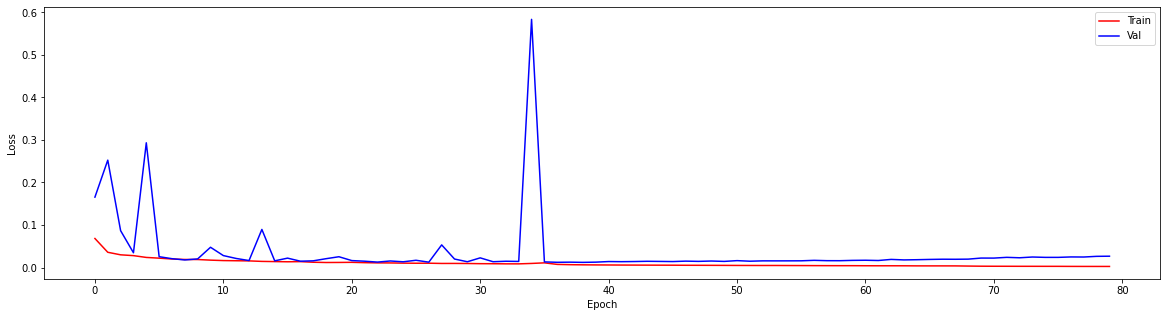

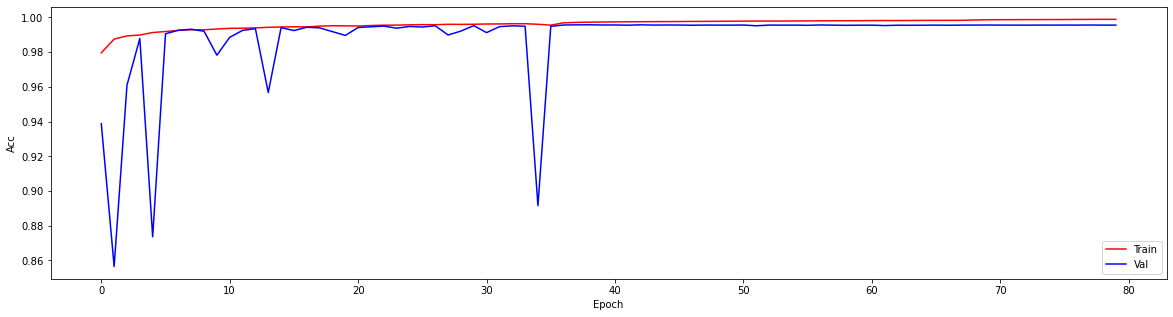

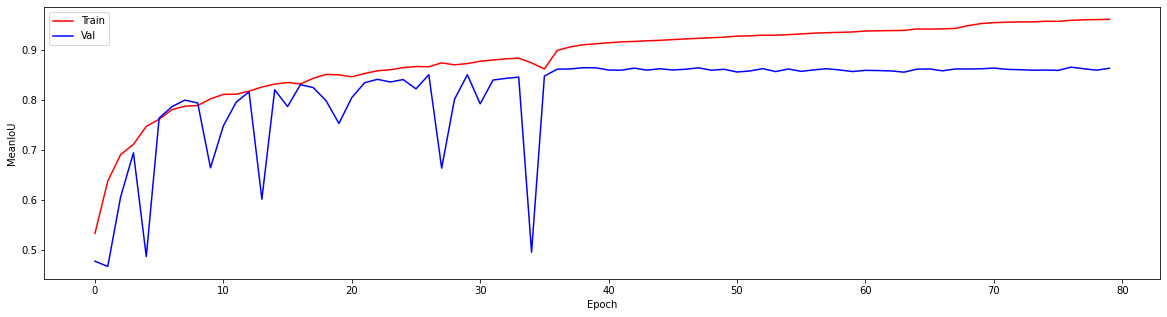

In [21]:
show_history(history, True)

In [22]:
from tensorflow.keras.models import load_model
model = load_model('resunet.h5', custom_objects = {'mean_iou': m.mean_iou})

IoU for class1 is: 0.9971284100131095
IoU for class2 is: 0.8880778588807786


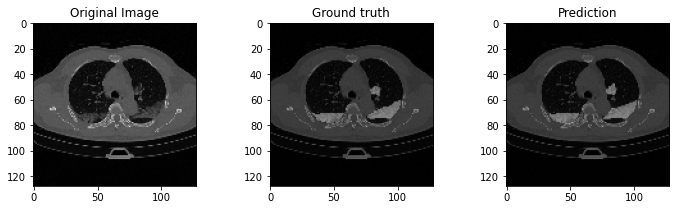

In [29]:
show_example(*all_valid_filenames[0], model, label, (128,128), 'rgb', kmean= kmean)